In [ ]:
1. 데이터 가져오기 및 분석.
2. 모델 타입 선정.
3. 모델 훈련.
4. 모델 효과 평가.
5. 예측을 위한 훈련된 모델 사용.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import matplotlib.pyplot as plt

import tensorflow as tf

tf.enable_eager_execution()

print("텐서플로 버전: {}".format(tf.__version__))
print("즉시 실행: {}".format(tf.executing_eagerly()))

텐서플로 버전: 1.13.1
즉시 실행: True


In [ ]:
# 훈련 데이터 가져오기 및 파싱 

In [2]:
## 데이터셋 다운로드 

train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

print("데이터셋이 복사된 위치: {}".format(train_dataset_fp))

데이터셋이 복사된 위치: C:\Users\bsww201\.keras\datasets\iris_training.csv


In [ ]:
## type {train_dataset_fp} -Head -5

# 처음 5개 항목 확인 
# 첫째줄 : header - 120개의 샘플이 있으며 각 샘플은 4개의 특성, 3개의 레이블을 가지고 있음 
120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0

In [3]:
# CSV 파일안에서 컬럼의 순서
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

feature_names = column_names[:-1]
label_name = column_names[-1]

print("특성: {}".format(feature_names))
print("레이블: {}".format(label_name))

특성: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
레이블: species


In [4]:
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

In [8]:
# 텐서플로의 Dataset API는 데이터를 적재할 때 발생하는 다양한 경우를 다룰 수 있습니다. 
# 데이터셋이 CSV 파일이므로, 적절한 형태로 데이터를 구분하기위해 make_csv_dataset 함수를 사용


batch_size = 32

# 훈련 모델을 위한 데이터 셋 생성하는 함수 : make_csv_dataset
# make_csv_dataset 함수는 (features, label) 쌍으로 구성된 tf.data.Dataset을 반환
train_dataset = tf.contrib.data.make_csv_dataset(
    train_dataset_fp,
    batch_size, 
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)

In [9]:
# # make_csv_dataset 함수는 (features, label) 쌍으로 구성된 tf.data.Dataset을 반환
# features는 딕셔너리 객체인: {'feature_name': value}로 주어짐 -> 즉시 실행 활성화로 이 Dataset은 반복가능

features, labels = next(iter(train_dataset))

features

(OrderedDict([('sepal_length',
               <tf.Tensor: id=139, shape=(32,), dtype=float32, numpy=
               array([6.1, 5.8, 6.3, 5.6, 5.4, 5.6, 6.5, 5.9, 5.5, 6.6, 6.5, 4.9, 6.8,
                      7.2, 6.4, 5.2, 7.2, 6.2, 7.3, 6.7, 5.8, 5.4, 5.4, 5. , 4.6, 4.9,
                      6.5, 5.2, 5. , 5. , 6.3, 5.8], dtype=float32)>),
              ('sepal_width',
               <tf.Tensor: id=140, shape=(32,), dtype=float32, numpy=
               array([2.8, 2.7, 3.3, 2.5, 3.7, 2.7, 2.8, 3.2, 3.5, 2.9, 3. , 3.1, 3.2,
                      3.2, 2.8, 3.4, 3.6, 2.2, 2.9, 3. , 4. , 3.4, 3.9, 2.3, 3.1, 2.4,
                      3.2, 3.5, 3.5, 3.3, 3.3, 2.7], dtype=float32)>),
              ('petal_length',
               <tf.Tensor: id=137, shape=(32,), dtype=float32, numpy=
               array([4.7, 4.1, 4.7, 3.9, 1.5, 4.2, 4.6, 4.8, 1.3, 4.6, 5.8, 1.5, 5.9,
                      6. , 5.6, 1.4, 6.1, 4.5, 6.3, 5. , 1.2, 1.5, 1.3, 3.3, 1.5, 3.3,
                      5.1, 1.5, 1.

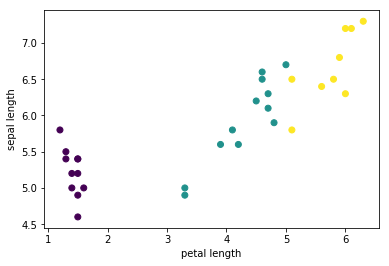

In [10]:
plt.scatter(features['petal_length'].numpy(),
            features['sepal_length'].numpy(),
            c=labels.numpy(),
            cmap='viridis')

plt.xlabel("petal length")
plt.ylabel("sepal length")

In [11]:
# 모델 구축단계를 단순화하기 위해 -> 특성 딕셔너리를 (batch_size, num_features)의 형태를 가지는 단일 배열로 다시 구성하는 함수 생성 

def pack_features_vector(features, labels):
  """Pack the features into a single array."""
    # 텐서플로우에서 axis 인자를 어떻게 설정하느냐에 따라 연산 기준이 다름
    # axis =1 : 행 안에서의 평균값을 의미 
  features = tf.stack(list(features.values()), axis=1)
  return features, labels


In [12]:
train_dataset = train_dataset.map(pack_features_vector)

In [15]:
# 데이터셋의 특성 요소는 이제 형태가 (batch_size, num_features)인 배열 
# 배치의 크기를 32로 했기 때문에 32개의 배열이 나오고 특징은 4개 이므로 각 배열에는 특징 4개의 값이 있음

features, labels = next(iter(train_dataset))

print(features)

tf.Tensor(
[[6.  3.  4.8 1.8]
 [6.1 2.8 4.7 1.2]
 [4.4 2.9 1.4 0.2]
 [5.4 3.7 1.5 0.2]
 [7.3 2.9 6.3 1.8]
 [7.7 3.8 6.7 2.2]
 [5.4 3.  4.5 1.5]
 [5.9 3.2 4.8 1.8]
 [6.3 2.7 4.9 1.8]
 [4.9 3.1 1.5 0.1]
 [6.5 3.  5.8 2.2]
 [6.3 3.3 6.  2.5]
 [5.2 2.7 3.9 1.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.1 3.8 1.5 0.3]
 [7.7 2.8 6.7 2. ]
 [7.2 3.6 6.1 2.5]
 [6.9 3.1 5.1 2.3]
 [4.7 3.2 1.6 0.2]
 [6.5 3.  5.2 2. ]
 [5.5 2.6 4.4 1.2]
 [6.4 3.2 4.5 1.5]
 [6.7 3.1 5.6 2.4]
 [5.7 2.8 4.5 1.3]
 [6.6 2.9 4.6 1.3]
 [5.6 2.9 3.6 1.3]
 [6.5 3.2 5.1 2. ]
 [5.8 2.6 4.  1.2]
 [6.5 2.8 4.6 1.5]
 [4.6 3.1 1.5 0.2]
 [5.7 2.8 4.1 1.3]], shape=(32, 4), dtype=float32)


In [ ]:
# 모델 타입 선정 

In [ ]:
## 모델을 사용해야 하는 이유
모델은 특성과 레이블과의 관계입니다. 
붓꽃 분류 문제에서 모델은 측정된 꽃받침과 꽃잎 사이의 관계를 정의하고 붓꽃의 품종을 예측

## 모델 선정 - 경험에 따름
신경망 모델 사용
신경망 : 하나 이상의 은닉층으로 구성됨 / 은닉층은 하나 이상의 뉴런으로 구성
여기서는 '완전 연결 신경망'을 사용할 것 - 하나의 뉴런에 이전층의 모든 뉴런의 입력을 받는 신경망
훈련된 모델에 레이블 되어 있지 않은 데이터를 제공했을 때, 모델은 주어진 데이터의 3가지(레이블개수) 예측을 출력함
이 예제에서 출력의 합은 1

In [16]:
## 케라스를 사용한 모델 생성 
## tf.keras.Sequential은 여러 층을 연이어 쌓은 모델

model = tf.keras.Sequential([
  ## 각 층당 10개의 노드를 가지는 2개의 완전연결층
  ## 3개의 예측(레이블 수) 노드를 가지는 출력 층으로 구성되어 있음 
    
  ### 첫번째 층의 input_shape 매개변수는 데이터셋의 특성의 수와 관계있음 ('sepal_length', 'sepal_width', 'petal_length', 'petal_width' -> 4개의 특성)
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])


### 활성화 함수는 각 층에서 출력의 크기를 결정한다 -> 이런 비션형성은 중요
### 활성화함수가 없는 모델은 하나의 층과 동일하다고 생각하면 됨
### ReLU가 은닉층에 주로 사용되는 활성화 함수이다. 

In [18]:
## 모델 사용 

## 이 모델이 특성의 배치에 대해 수행하는 작업결과 (배치 크기 : 32)
predictions = model(features)
predictions

<tf.Tensor: id=326, shape=(32, 3), dtype=float32, numpy=
array([[0.7415524 , 2.5088804 , 2.669544  ],
       [0.6408385 , 2.5853138 , 2.7420964 ],
       [0.75071704, 1.949897  , 2.5778384 ],
       [0.97055644, 2.4106443 , 3.2415771 ],
       [0.65098524, 2.980216  , 3.0306811 ],
       [1.0861672 , 3.328456  , 3.523975  ],
       [0.8918382 , 2.4199347 , 2.6271148 ],
       [0.8867469 , 2.557949  , 2.7653217 ],
       [0.49881566, 2.4801183 , 2.5607786 ],
       [0.7840396 , 2.146587  , 2.8485298 ],
       [0.81895816, 2.6844301 , 2.798151  ],
       [1.0895185 , 2.7137678 , 2.8921118 ],
       [0.6351412 , 2.1985242 , 2.3634896 ],
       [1.008715  , 2.3926668 , 3.2606053 ],
       [0.89746296, 2.2489297 , 3.0233407 ],
       [1.0631068 , 2.3676953 , 3.1763577 ],
       [0.55298305, 3.042801  , 3.0408144 ],
       [0.96176755, 2.9912777 , 3.1736999 ],
       [0.5245114 , 2.6361623 , 2.7469678 ],
       [0.87052155, 2.1396294 , 2.8134878 ],
       [0.6627141 , 2.622511  , 2.7447362 ]

In [19]:
## 각 샘플은 각 클래스에 대한 logit을 반환
## 이 logit을 각 클래스에 대한 확률로 변환하기 위해서 softmax 함수를 사용 

# logit 이란 ? 
## 분류모델에서 생성되는 원시예측벡터로, 대개는 정규화 함수로 전달된다. 
## 모델에서 다중 클래스 분류 문제를 해결하고 있는 경우 logit은 softmax 함수의 입력으로 사용되는 것이 일반적
## softmax 함수에서 가능한 클래스별로 하나의 값을 갖는 (정규화된)확률 벡터를 생성

# softmax 함수란 ?
## 인공신경망이 내놓은 k개의 클래스 구분 결과를 확률처럼 해석하도록 만들어줌 
## 보통은 output노드 바로 뒤에 부착됨 


# 원시예측벡터인 predictions에 정규화함수인 softmax를 붙임으로써 클래스 구분 결과를 확률처럼 해석가능하게 함 
tf.nn.softmax(predictions)

<tf.Tensor: id=328, shape=(32, 3), dtype=float32, numpy=
array([[0.07282857, 0.42642492, 0.5007465 ],
       [0.06185665, 0.43237564, 0.50576764],
       [0.09493645, 0.31494173, 0.59012187],
       [0.0670675 , 0.28309634, 0.64983606],
       [0.04530697, 0.46530437, 0.48938859],
       [0.04573986, 0.43063408, 0.523626  ],
       [0.08865335, 0.40863827, 0.50270844],
       [0.07774399, 0.4134859 , 0.50877005],
       [0.06205949, 0.45006686, 0.48787367],
       [0.07820191, 0.30546692, 0.61633116],
       [0.06804626, 0.43950972, 0.49244398],
       [0.08237257, 0.41800848, 0.49961895],
       [0.08767089, 0.41862395, 0.49370512],
       [0.06898299, 0.2752863 , 0.65573066],
       [0.07550965, 0.29170045, 0.63278985],
       [0.07715292, 0.28439894, 0.6384481 ],
       [0.0398498 , 0.48055196, 0.47959828],
       [0.05635802, 0.42890465, 0.51473737],
       [0.05407789, 0.4467845 , 0.49913764],
       [0.0866769 , 0.3083684 , 0.6049547 ],
       [0.06204029, 0.44035488, 0.49760482]

In [20]:
## tf.argmax는 예측된 값 중 가장 큰 확률(원하는 클래스)을 반환

print("예측: {}".format(tf.argmax(predictions, axis=1)))
print("    레이블: {}".format(labels))

## 아직 모델을 훈련시키지 않았으므로 좋은 예측 아님 

예측: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
    레이블: [2 1 0 0 2 2 1 1 2 0 2 2 1 0 0 0 2 2 2 0 2 1 1 2 1 1 1 2 1 1 0 1]


In [ ]:
# 모델 훈련하기 
훈련 단계는 모델이 점진적으로 최적화되거나 데이터셋을 학습하는 머신러닝의 과정이다. 
훈련의 목적은 미지의 데이터를 예측하기 위해 훈련 데이터셋의 구조에 대해 충분히 학습하는 것
훈련 데이터셋에 과하게 학습되면 -> 오직 훈련데이터셋에 대해서 작동 -> 일반화 힘듬 -> 과대적합

* 지도학습 : 모델이 레이블을 포함한 훈련 데이터로부터 학습됨
* 비지도학습 : 훈련 데이터가 레이블을 포함하고 있지 않음. 대신 모델은 특성간의 패턴을 찾음 
    
--> 붓꽃 예제는 지도학습의 예

In [21]:
## 손실함수와 그래디언트 함수 정의하기 

### 훈련과 평가단계에서 모델의 loss를 계산해야한다 
### 손실은 모델의 예측이 원하는 레이블과 얼마나 일치하는지, 또한 모델이 잘 작동하는지에 대한 척도로 사용됨 


### 모델의 손실은 tf.keras.losses.categorical_crossentropy 함수를 사용해 계산할 것
    ### -> 해당 함수는 모델의 레이블(클래스)와 예측된 값(로짓)을 입력받아 샘플의 평균 손실을 반환한다. 
    
    
def loss(model, x, y):
  y_ = model(x)
  return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)


l = loss(model, features, labels)
print("손실 테스트: {}".format(l))

Instructions for updating:
Use tf.cast instead.
손실 테스트: 1.2201368808746338


In [22]:
## 손실함수와 그래디언트 함수 정의하기 

### 모델을 최적화하기 위해 사용되는 gradient를 계산하기 위해  tf.GradientTape 컨텍스트를 사용

def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [28]:
## 옵티마이저 생성 

### 옵티마이저는 손실함수를 최소화하기 위해 계산된 그래디언트를 모델의 변수에 적용 


### tensorflow는 훈련을 위해 사용 가능한 여러종류의 최적화 알고리즘을 가지고 있습니다. 
### 이번 모델에서는  확률적 경사 하강법(stochastic gradient descent, SGD) 을 구현한 tf.train.GradientDescentOptimizer를 사용
### learning_rate은 경사하강 과정의 크기를 나타내는 매개변수 --> 더 나음 결과를 위해 조절 가능한 hyperparameter 이다. 


optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.01)

## 몇번째 단계인지 계산하기 위한 변수 
## tf.contrib.eager.Variable(0) -> 0으로 초기화해서 globalstep에 저장 
global_step = tf.contrib.eager.Variable(0)



# 손실 계산의 첫단계 결과를 위한 것 
loss_value, grads = grad(model, features, labels)

print("단계: {}, 초기 손실: {}".format(global_step.numpy(),
                                          loss_value.numpy()))

# 첫단계에서 나온 grads 를 이용해 최적화 하기 
# apply_gradients(grads_and_vars,global_step=None,name=None)
## grads_and_vars를 같이 주기 위해 zip 사용 -> compute_gradients()를 반환해줌 
## global_step 을 증가시키기위해 넣어줌
optimizer.apply_gradients(zip(grads, model.trainable_variables), global_step)

# 위단계에서 최적화한 결과를 출력 (단계와 손실정도)
print("단계: {},      손실: {}".format(global_step.numpy(),
                                          loss(model, features, labels).numpy()))

단계: 0, 초기 손실: 1.1810835599899292
단계: 1,      손실: 1.154321551322937


In [29]:
## 훈련 루프 
### 훈련 루프는 더 좋은 예측을 위해 데이터셋을 모델로 제공 

'''
1. 각 에포크 반복
2. 에포크 내에서, 특성(x)와 레이블(y)가 포함된 훈련 데이터셋에 있는 샘플을 반복 
3. 샘플의 특성을 사용해 결과를 예측하고 레이블과 비교
    -> 예측의 부정확도 측정, 모델의 손실과 그래디언트 계산하기 위해 사용
4. 모델의 변수를 업데이트하기 위해 옵티마이저 사용 
5. 시각화를 위해 몇가지 값들을 저장
6. 각 에포크를 반복 
'''

## Note: 이 셀을 다시 실행하면 동일한 모델의 변수가 사용됩니다.

from tensorflow import contrib
tfe = contrib.eager

# 도식화를 위해 결과를 저장합니다.
train_loss_results = []
train_accuracy_results = []

## 데이터셋 반복 횟수 -> 조정가능한 hyperparameter
num_epochs = 201

## 정한 반복횟수만큼 반복 
for epoch in range(num_epochs):
  epoch_loss_avg = tfe.metrics.Mean()
  epoch_accuracy = tfe.metrics.Accuracy()

  # 훈련 루프 - 32개의 배치를 사용합니다.
  # 특성 x, 레이블 y
  for x, y in train_dataset:
    # 모델을 최적화합니다.
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables),
                              global_step)

    # 진행 상황을 추적합니다.
    epoch_loss_avg(loss_value)  # 현재 배치 손실을 추가합니다.
    # 예측된 레이블과 실제 레이블 비교합니다.
    epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)

  # epoch 종료
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())
  
  # 50 에포크마다 결과 출력 
  if epoch % 50 == 0:
    print("에포크 {:03d}: 손실: {:.3f}, 정확도: {:.3%}".format(epoch, 
                                                              epoch_loss_avg.result(), 
                                                              epoch_accuracy.result()))

에포크 000: 손실: 1.228, 정확도: 25.833%
에포크 050: 손실: 0.463, 정확도: 73.333%
에포크 100: 손실: 0.307, 정확도: 97.500%
에포크 150: 손실: 0.226, 정확도: 98.333%
에포크 200: 손실: 0.149, 정확도: 96.667%


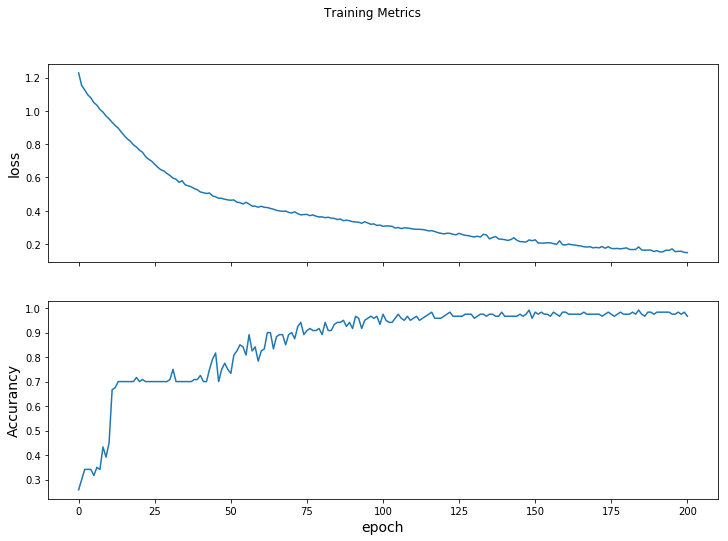

In [31]:
## 시간에 따른 손실함수 시각화 

###  텐서보드(tensorboard)는 텐서플로에 패키지 되어있는 굉장히 유용한 시각화 툴입니다. 하지만 matplotlib 모듈을 사용하여 일반적인 도표를 출력할 수 있습니다.

'''원하는 결과 - 손실이 내려가고 정확도가 올라가는 것을 원함'''


fig, axes = plt.subplots(2, sharex=True, figsize=(12,8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accurancy", fontsize=14)
axes[1].set_xlabel("epoch", fontsize=14)
axes[1].plot(train_accuracy_results)

In [ ]:
# 모델 유효성 평가 

평가는 모델이 예측을 얼마나 효과적으로 수행하는지 결정하는 것을 의미 
붓꽃 분류 모델의 유효성을 결정하기 위해, 몇가지 꽃잎과 꽃받침 데이터를 통과시키고 어떠한 품종을 예측하는지 확인
그 후 실제 품종과 비교

In [32]:
## 테스트 데이터 세트 설정 

### 모델의 훈련과 비슷하지만 훈련데이터가 아닌 테스트 데이터 셋을 사용한다. 
### 공정하게 모델의 유효성을 평가하기 위해, 모델을 평가하기 위한 샘플은 반드시 훈련데이터와 달라야한다. 

### SV 파일을 다운로드하고 값을 파싱합니다. 그 후 셔플은 적용하지 않습니다.

test_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

8192/573 [============================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0s/step


In [33]:
# csv 데이터셋을 make_csv_dataset을 사용해 테스트 데이터셋으로 사용한다 

test_dataset = tf.contrib.data.make_csv_dataset(
    test_fp,
    batch_size, 
    column_names=column_names,
    label_name='species',
    num_epochs=1,
    shuffle=False)

test_dataset = test_dataset.map(pack_features_vector)

In [34]:
## 테스트 데이터 세트를 사용한 모델 평가 


### 모델은 테스트 데이터에 대해서 오직 한 번의 에포크를 진행

test_accuracy = tfe.metrics.Accuracy()

for (x, y) in test_dataset:
  logits = model(x)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print("테스트 세트 정확도: {:.3%}".format(test_accuracy.result()))

테스트 세트 정확도: 100.000%


In [35]:
tf.stack([y,prediction],axis=1)

<tf.Tensor: id=108565, shape=(30, 2), dtype=int32, numpy=
array([[1, 1],
       [2, 2],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [2, 2],
       [1, 1],
       [2, 2],
       [2, 2],
       [0, 0],
       [2, 2],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [2, 2],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 1]])>

In [36]:
# 훈련된 모델로 예측하기 

## 훈련된 모델을 사용하여 '레이블되지 않은 데이터'를 예측해보기 


predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

## 레이블은 다음과 같은 붓꽃 이름으로 매핑되어있습니다. * 0: Iris setosa * 1: Iris versicolor * 2: Iris virginica

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  print("예 {} 예측: {} ({:4.1f}%)".format(i, name, 100*p))

예 0 예측: Iris setosa (97.9%)
예 1 예측: Iris versicolor (86.6%)
예 2 예측: Iris virginica (69.0%)
